# Recomputing MOXSI Overlappograms

In [1]:
import sys

import astropy.units as u
import astropy.wcs
from astropy.coordinates import SkyCoord
import astropy.constants as const
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sunpy.map
from sunpy.map.maputils import extract_along_coord, contains_coordinate
from astropy.visualization import (ImageNormalize, LogStretch, SqrtStretch, AsinhStretch,
                                   AsymmetricPercentileInterval, quantity_support)
import distributed
from ndcube import NDCube

from overlappy.reproject import reproject_to_overlappogram
from overlappy.util import color_lat_lon_axes, strided_array
from overlappy.io import write_overlappogram, read_overlappogram

sys.path.append('../../')
from mocksipipeline.physics import read_spectral_cube
from mocksipipeline.detector import Channel, SpectrogramChannel, convolve_with_response

In [2]:
client = distributed.Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57200,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57225,Total threads: 2
Dashboard: http://127.0.0.1:57228/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:57205,


In this notebook, I'm just recomputing the MOXSI overlappogram for the AR case, but this time, I'm not including the gain calculation such that the units of the overlappogram will be in photons rather than DN.

In [4]:
spectral_cube = read_spectral_cube('moxsi-spectral-cube-ar.fits',hdu=1)

In [5]:
observer = astropy.wcs.utils.wcs_to_celestial_frame(spectral_cube.wcs).observer

In [6]:
observer

<HeliographicStonyhurst Coordinate (obstime=2020-11-09T18:00:06.640, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.006005, 3.43378555, 1.48126201e+11)>

In [7]:
order = 1
chan = SpectrogramChannel(order, '../../mocksipipeline/data/MOXSI_effarea.genx')
instr_cube = convolve_with_response(spectral_cube, chan, include_gain=False)
overlap = reproject_to_overlappogram(
    instr_cube,
    chan.detector_shape,
    observer=observer,
    reference_pixel=(
        (chan.detector_shape[1] + 1)/2,
        (chan.detector_shape[0] + 1)/2,
        1,
    ) * u.pix,
    reference_coord=(
        0 * u.arcsec,
        0 * u.arcsec,
        instr_cube.axis_world_coords(0)[0].to('angstrom')[0],
    ),
    scale=(
        chan.resolution[0],
        chan.resolution[1],
        chan.spectral_resolution,
    ),
    roll_angle=-90*u.deg,
    dispersion_angle=0*u.deg,
    dispersion_axis=0,
    order=chan.spectral_order,
    meta_keys=['CHANNAME'],
    use_dask=True,
    sum_over_lambda=True,
    algorithm='interpolation',
)

Text(0.5, 1.0, 'order=1')

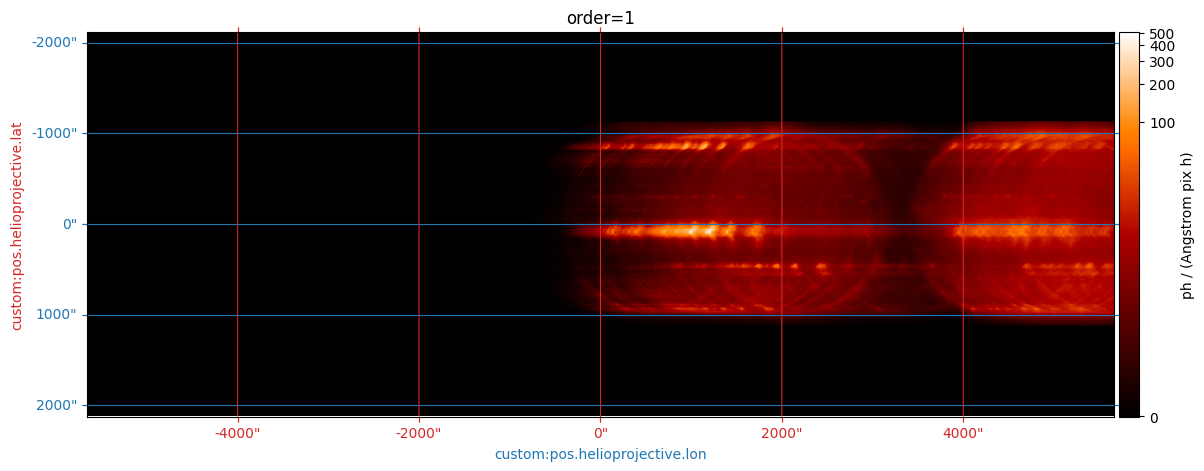

In [10]:
fig = plt.figure(figsize=(15,5))
wave_index = 0
ax = fig.add_subplot(111, projection=overlap[wave_index].wcs)
plot_unit = 'ph / (Angstrom pix h)'
#vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
#    u.Quantity(total_overlap[wave_index].data, total_overlap.unit).to_value(plot_unit),
#)
overlap[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(stretch=LogStretch()),
    data_unit=plot_unit
)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title(f'order={order}')

In [18]:
overlappogram_components = {}
spectral_orders = [-3, -1, 0, 1, 3]
for order in spectral_orders:
    print(f'Computing overlap for order={order}')
    chan = SpectrogramChannel(order, '../../mocksipipeline/data/MOXSI_effarea.genx')
    instr_cube = convolve_with_response(spectral_cube, chan, include_gain=False)
    overlap = reproject_to_overlappogram(
        instr_cube,
        chan.detector_shape,
        observer=observer,
        reference_pixel=(
            (chan.detector_shape[1] + 1)/2,
            (chan.detector_shape[0] + 1)/2,
            1,
        ) * u.pix,
        reference_coord=(
            0 * u.arcsec,
            0 * u.arcsec,
            instr_cube.axis_world_coords(0)[0].to('angstrom')[0],
        ),
        scale=(
            chan.resolution[0],
            chan.resolution[1],
            chan.spectral_resolution,
        ),
        roll_angle=-90*u.deg,
        dispersion_angle=0*u.deg,
        dispersion_axis=0,
        order=chan.spectral_order,
        meta_keys=['CHANNAME'],
        use_dask=True,
        sum_over_lambda=True,
        algorithm='interpolation',
    )
    write_overlappogram(overlap, f'overlappogram-ar-photons-order={order}.fits')
    overlappogram_components[order] = overlap

Computing overlap for order=-3


Computing overlap for order=-1


Computing overlap for order=0


2022-08-31 10:18:37,793 - distributed.worker_memory - WARNING - gc.collect() took 3.328s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


Computing overlap for order=1


Computing overlap for order=3


2022-08-31 10:32:46,633 - distributed.worker_memory - WARNING - gc.collect() took 4.476s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


In [4]:
overlappogram_components = {
    -3: read_overlappogram('overlappogram-ar-photons-order=-3.fits'),
    -1: read_overlappogram('overlappogram-ar-photons-order=-1.fits'),
    0: read_overlappogram('overlappogram-ar-photons-order=0.fits'),
    1: read_overlappogram('overlappogram-ar-photons-order=1.fits'),
    3: read_overlappogram('overlappogram-ar-photons-order=3.fits'),
}

In [5]:
def get_full_overlappogram(components, order):
    data = np.array([components[k].data[0] for k in components]).sum(axis=0)
    wcs = components[order].wcs
    data_strided = strided_array(data, components[order].data.shape[0])
    return NDCube(data_strided, wcs=wcs, unit=components[order].unit, meta=components[order].meta)

In [6]:
total_overlap = get_full_overlappogram(overlappogram_components, 0)

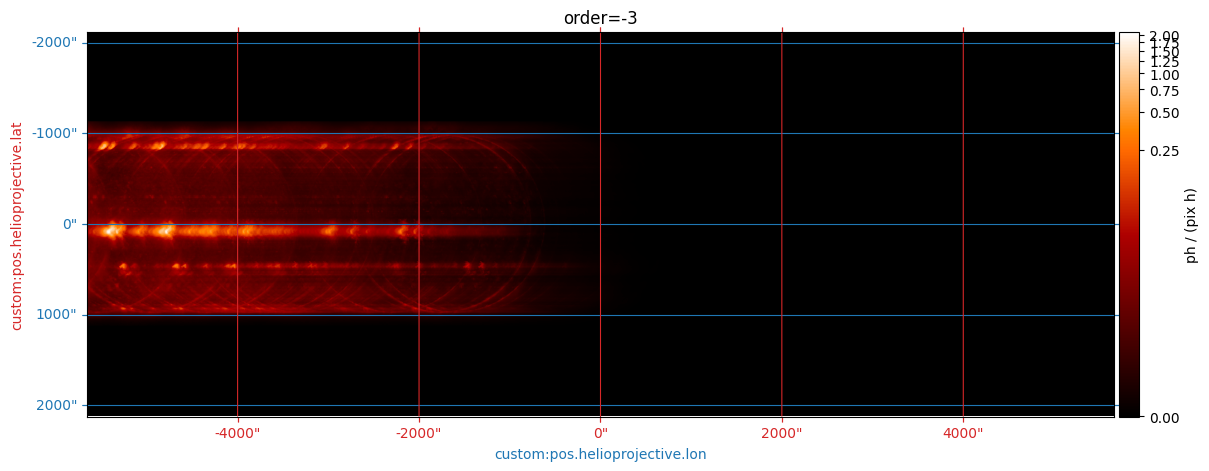

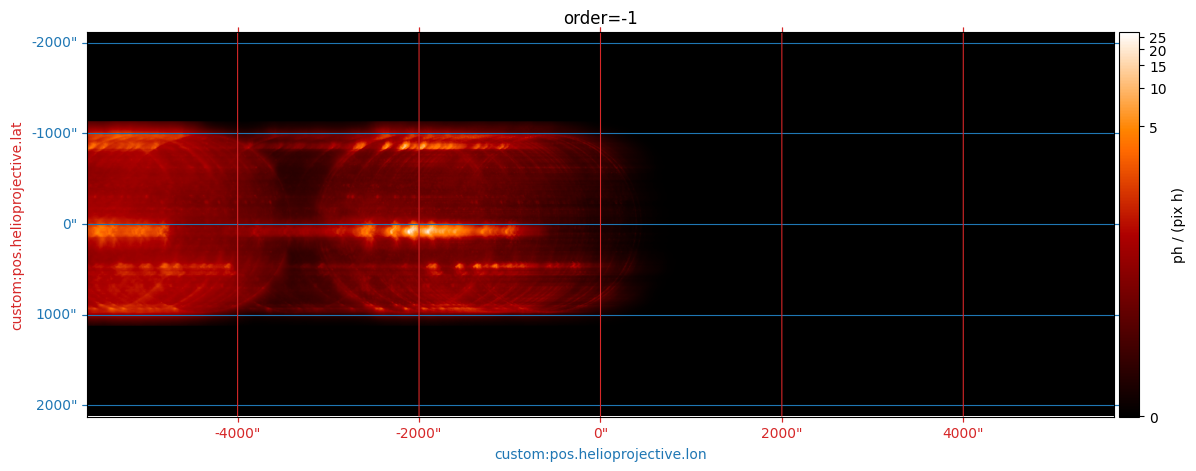

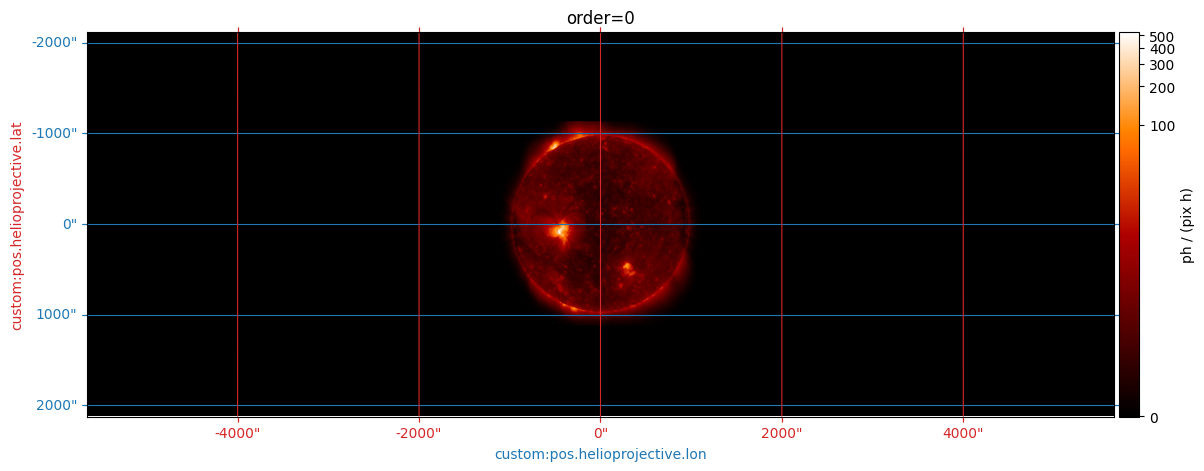

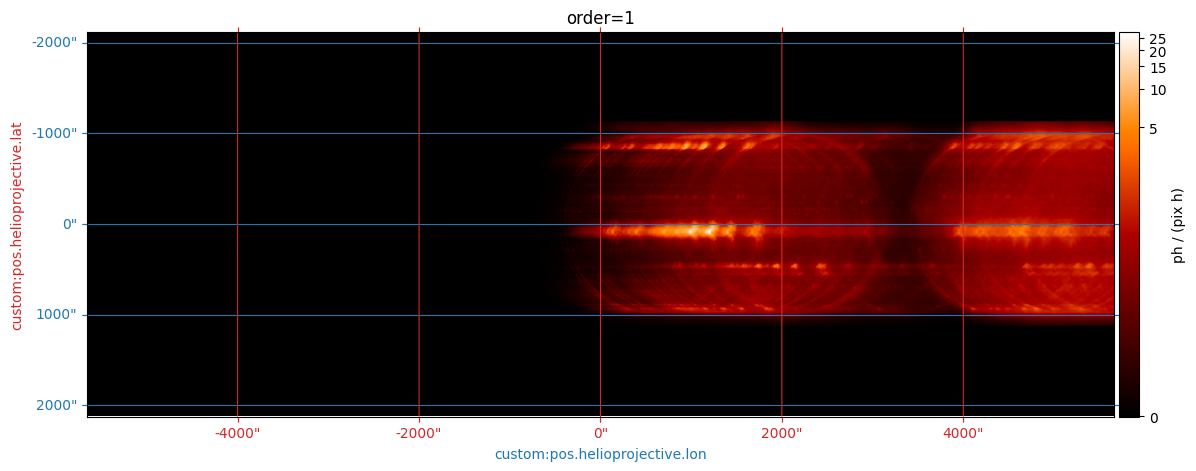

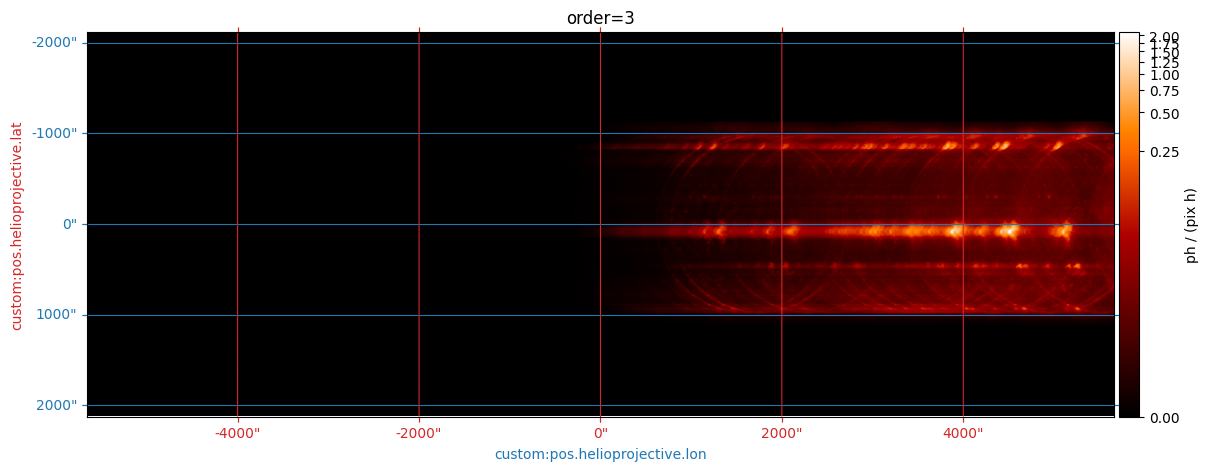

In [7]:
for k,v in overlappogram_components.items():
    fig = plt.figure(figsize=(15,5))
    wave_index = 0
    ax = fig.add_subplot(111, projection=v[wave_index].wcs)
    plot_unit = 'ph / (pix h)'
    #vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
    #    u.Quantity(total_overlap[wave_index].data, total_overlap.unit).to_value(plot_unit),
    #)
    v[wave_index].plot(
        axes=ax,
        cmap='hinodexrt',
        norm=ImageNormalize(stretch=LogStretch()),
        data_unit=plot_unit
    )
    im = ax.get_images()[0]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position("right")
    cbar.set_label(f'{plot_unit}',)
    color_lat_lon_axes(ax)
    ax.set_title(f'order={k}')

In [8]:
hpc_frame = astropy.wcs.utils.wcs_to_celestial_frame(total_overlap.wcs)
endpoints = SkyCoord(Tx=([100,100]*u.arcsec), Ty=([-5600,5600]*u.arcsec), frame=hpc_frame)
lower = SkyCoord(Tx=[275,275]*u.arcsec,Ty=[-650,5600]*u.arcsec,frame=hpc_frame)
upper = SkyCoord(Tx=[-150,-150]*u.arcsec,Ty=[-650,5600]*u.arcsec,frame=hpc_frame)
blc = SkyCoord(Tx=-150*u.arcsec,Ty=-650*u.arcsec,frame=hpc_frame)
trc = SkyCoord(Tx=275*u.arcsec, Ty=5600*u.arcsec,frame=hpc_frame)

Text(0.5, 1.0, 'All orders')

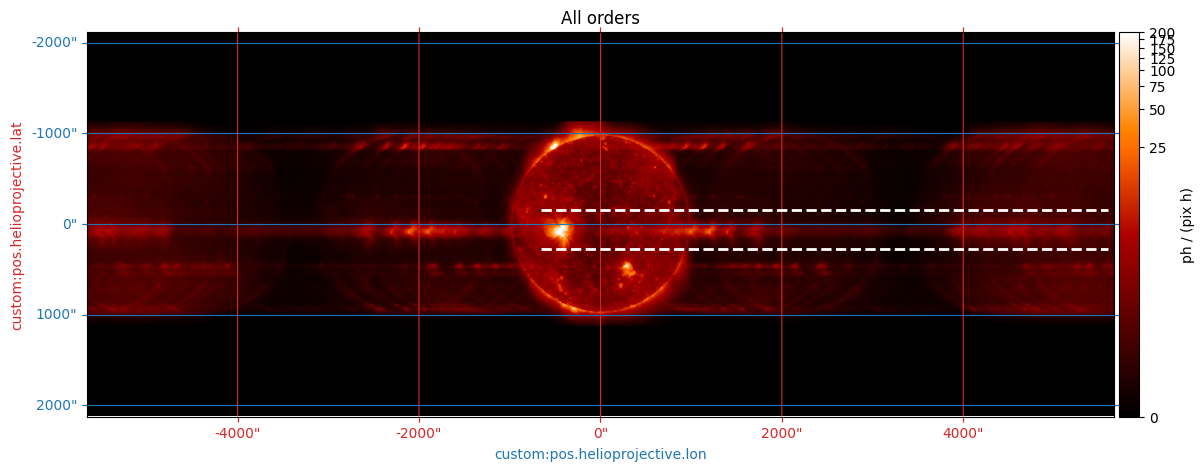

In [168]:
fig = plt.figure(figsize=(15,5))
wave_index = 0
ax = fig.add_subplot(111, projection=total_overlap[wave_index].wcs)
plot_unit = 'ph / (pix h)'
#vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
#    u.Quantity(total_overlap[wave_index].data, total_overlap.unit).to_value(plot_unit),
#)
total_overlap[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmax=200,stretch=LogStretch()),
    data_unit=plot_unit
)
ax.plot_coord(lower, ls='--', color='w', lw=2)
ax.plot_coord(upper, ls='--', color='w', lw=2)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title('All orders')
#fig.savefig('overlap-all-orders.png')

In [10]:
row_lower, col_lower = total_overlap[0].wcs.world_to_array_index(lower)
row_upper, col_upper = total_overlap[0].wcs.world_to_array_index(upper)

Text(0.0, 0.8333333333333334, 'All orders')

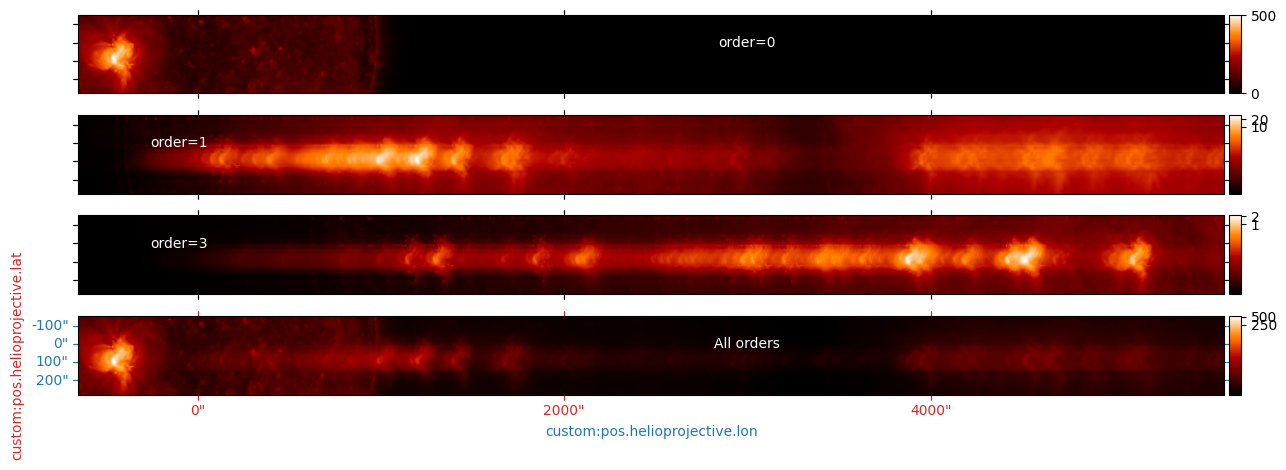

In [94]:
fig = plt.figure(figsize=(15, 5))

# Order=0
cropped_slice = overlappogram_components[0][0].crop(blc, trc)
ax = fig.add_subplot(4,1,1, projection=cropped_slice.wcs)
cropped_slice.plot(axes=ax,
                   cmap='hinodexrt',
                   data_unit='ph pix-1 h-1',
                   norm=ImageNormalize(stretch=LogStretch()))
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
ax.text((0*u.arcsec).to('deg').value,
        (3000*u.arcsec).to('deg').value,
        'order=0',
        transform=ax.get_transform('world'),
        horizontalalignment='center',
        verticalalignment='center',
        color='w')

# Order=1
cropped_slice = overlappogram_components[1][0].crop(blc, trc)
ax = fig.add_subplot(4,1,2, projection=cropped_slice.wcs)
cropped_slice.plot(axes=ax,
                   cmap='hinodexrt',
                   data_unit='ph pix-1 h-1',
                   norm=ImageNormalize(stretch=LogStretch()))
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
ax.text((0*u.arcsec).to('deg').value,
        (-100*u.arcsec).to('deg').value,
        'order=1',
        transform=ax.get_transform('world'),
        horizontalalignment='center',
        verticalalignment='center',
        color='w')

# Order=3
cropped_slice = overlappogram_components[3][0].crop(blc, trc)
ax = fig.add_subplot(4,1,3, projection=cropped_slice.wcs)
cropped_slice.plot(axes=ax,
                   cmap='hinodexrt',
                   data_unit='ph pix-1 h-1',
                   norm=ImageNormalize(stretch=LogStretch()))
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
ax.text((0*u.arcsec).to('deg').value,
        (-100*u.arcsec).to('deg').value,
        'order=3',
        transform=ax.get_transform('world'),
        horizontalalignment='center',
        verticalalignment='center',
        color='w')

# Total
cropped_slice = total_overlap[0].crop(blc, trc)
ax = fig.add_subplot(4,1,4, projection=cropped_slice.wcs)
cropped_slice.plot(axes=ax,
                   cmap='hinodexrt',
                   data_unit='ph pix-1 h-1',
                   norm=ImageNormalize(stretch=LogStretch()))
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
color_lat_lon_axes(ax,)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.text((0*u.arcsec).to('deg').value,
        (3000*u.arcsec).to('deg').value,
        'All orders',
        transform=ax.get_transform('world'),
        horizontalalignment='center',
        verticalalignment='center',
        color='w')
#fig.savefig('overlap-components-cutout.png')

In [149]:
intensity_total_sum = u.Quantity(cropped_slice.data.sum(axis=0), cropped_slice.unit)
pix_coords = np.linspace(0, cropped_slice.data.shape[1]-1, cropped_slice.data.shape[1])
cropped_coords = cropped_slice.wcs.pixel_to_world(pix_coords, 0)
cropped_coords_diff = cropped_coords.separation(cropped_coords[0]).to('arcsec')

In [150]:
intensity_order0_sum = u.Quantity(overlappogram_components[0][0].crop(blc, trc).data.sum(axis=0),
                                  cropped_slice.unit)
intensity_order1_sum = u.Quantity(overlappogram_components[1][0].crop(blc, trc).data.sum(axis=0),
                                  cropped_slice.unit)
intensity_order3_sum = u.Quantity(overlappogram_components[3][0].crop(blc, trc).data.sum(axis=0),
                                  cropped_slice.unit)

(-648.0672935647827, 5599.189314101428)

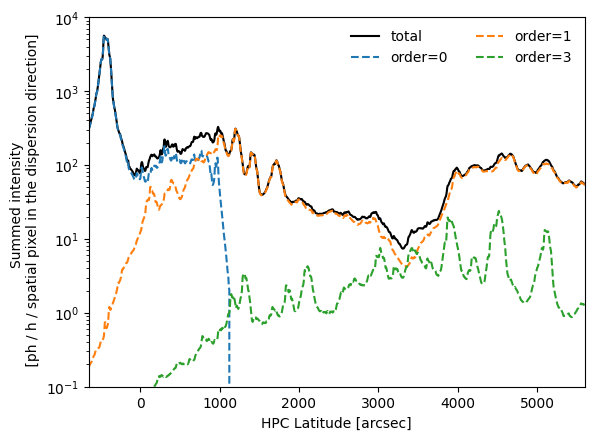

In [112]:
with quantity_support():
    plt.plot(cropped_coords.Ty, intensity_total_sum.to('ph h-1'), label='total', color='k')
    plt.plot(cropped_coords.Ty, intensity_order0_sum.to('ph h-1'), label='order=0', ls='--')
    plt.plot(cropped_coords.Ty, intensity_order1_sum.to('ph h-1'), label='order=1', ls='--')
    plt.plot(cropped_coords.Ty, intensity_order3_sum.to('ph h-1'), label='order=3', ls='--')
    #plt.axhline(y=1*u.Unit('ph h-1'), ls=':', lw=1, color='k')
plt.yscale('log')
plt.ylabel('Summed intensity \n [ph / h / spatial pixel in the dispersion direction]')
plt.xlabel('HPC Latitude [arcsec]')
plt.legend(loc=1,ncol=2,frameon=False)
plt.ylim(1e-1, 1e4)
plt.xlim(cropped_coords.Ty[[0,-1]].to_value('arcsec'))

In [151]:
wavelengths = total_overlap.axis_world_coords(0)[0]

In [152]:
total_overlap_o1 = get_full_overlappogram(overlappogram_components, 1)

In [153]:
px_cutout, py_cutout, _ = total_overlap_o1.wcs.world_to_pixel(cropped_coords, wavelengths[0])

In [154]:
_, wave_locs_o1 = total_overlap_o1.wcs.pixel_to_world(px_cutout,
                                                    py_cutout,
                                                    np.linspace(0,px_cutout.shape[0]-1, px_cutout.shape[0]))

In [155]:
wave_locs_o1

<SpectralCoord 
   (target: <Helioprojective Coordinate (obstime=2020-11-09T18:00:06.640, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2020-11-09T18:00:06.640, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
                (0.006005, 3.43378555, 1.48126201e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, kpc)
                (0., 0., 1000.)
             (d_Tx, d_Ty, d_distance) in (arcsec / s, arcsec / s, km / s)
                (0., 0., 0.)>)
  [1.05499995e-10, 1.10999995e-10, 1.16499995e-10, ..., 6.16649999e-09,
   6.17199999e-09, 6.17749999e-09] m>

In [156]:
chan_o1 = SpectrogramChannel(1, '../../mocksipipeline/data/MOXSI_effarea.genx')

In [157]:
intensity_order0_sum / chan_o1.spectral_resolution

<Quantity [1.53896963, 1.57310256, 1.63820592, ..., 0.        , 0.        ,
           0.        ] ph / (Angstrom s)>

(1.0549999475478997, 60.01499994754789)

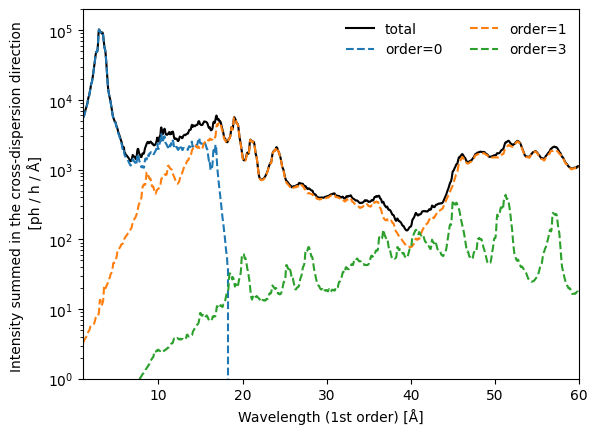

In [170]:
#fig = plt.figure(figsize=(10,6))
with quantity_support():
    plt.plot(wave_locs_o1.to('Angstrom'),
             (intensity_total_sum / chan_o1.spectral_resolution).to('ph h-1 Angstrom-1'),
             label='total', color='k')
    plt.plot(wave_locs_o1, (intensity_order0_sum / chan_o1.spectral_resolution).to('ph h-1 Angstrom-1'), 
             label='order=0', ls='--')
    plt.plot(wave_locs_o1, (intensity_order1_sum / chan_o1.spectral_resolution).to('ph h-1 Angstrom-1'), 
             label='order=1', ls='--')
    plt.plot(wave_locs_o1, (intensity_order3_sum / chan_o1.spectral_resolution).to('ph h-1 Angstrom-1'), 
             label='order=3', ls='--')
    #plt.axhline(y=1*u.Unit('ph h-1'), ls=':', lw=1, color='k')
plt.yscale('log')
plt.ylabel('Intensity summed in the cross-dispersion direction \n [ph / h / Å]')
plt.xlabel('Wavelength (1st order) [Å]')
plt.legend(loc=1,ncol=2,frameon=False)
plt.ylim(1, 2e5)
plt.xlim(wavelengths[[0,-1]].to_value('Angstrom'))

## Sandbox

In [21]:
intensity, coord = extract_along_coord(total_overlap[0],endpoints)

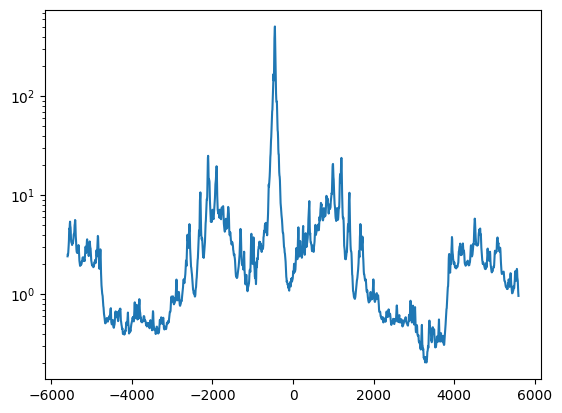

In [23]:
plt.plot(coord.Ty, intensity.to('ph / (pix h)'))
plt.yscale('log')

In [84]:
chan = SpectrogramChannel(0, '../../mocksipipeline/data/MOXSI_effarea.genx')
instr_cube = convolve_with_response(spectral_cube, chan, include_gain=False,)

In [86]:
instr_cube = NDCube(instr_cube.data*chan.spectral_resolution.to_value(),
                    wcs=instr_cube.wcs,
                    meta=instr_cube.meta,
                    unit=instr_cube.unit * chan.spectral_resolution.unit * u.pix)

28.554973721504407 Angstrom
0.434194755850289 keV


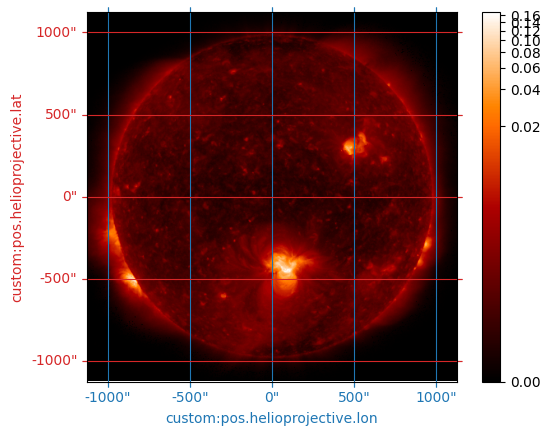

In [87]:
wave_index = 500
print(instr_cube.axis_world_coords(0)[0][wave_index].to('angstrom'))
print((const.h * const.c / instr_cube.axis_world_coords(0)[0][wave_index].to('angstrom')).to('keV'))
fig = plt.figure()
ax = fig.add_subplot(111,projection=instr_cube[wave_index].wcs)
instr_cube[wave_index].plot(axes=ax,
                     cmap='hinodexrt',
                     norm=ImageNormalize(stretch=LogStretch()),
                     data_unit='ph / (pix h)'
                    )
color_lat_lon_axes(ax)
plt.colorbar()

In [105]:
trc.Tx - blc.Tx

<Angle 425. arcsec>

In [101]:
cropped_slice.wcs.pixel_to_world(0,0)

<SkyCoord (Helioprojective: obstime=2020-11-09T18:00:06.640, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2020-11-09T18:00:06.640, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.006005, 3.43378555, 1.48126201e+11)>): (Tx, Ty) in arcsec
    (274.50983793, -648.06729356)>

In [104]:
cropped_slice.wcs.pixel_to_world(cropped_slice.dimensions[1].value-1,
                                 cropped_slice.dimensions[0].value-1)

<SkyCoord (Helioprojective: obstime=2020-11-09T18:00:06.640, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2020-11-09T18:00:06.640, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.006005, 3.43378555, 1.48126201e+11)>): (Tx, Ty) in arcsec
    (-149.98997356, 5599.19279065)>